# Gas-Turbine CO and NOx Emission Data

**Industrial gas turbines for power generation**

## Spis treści

1. Wykaz oznaczeń do opisu danych
2. Import bibliotek
3. Analiza zbioru danych


## 1. Wykaz oznaczeń do opisu danych


1) **AT**: *temperatura powietrza, &degC;*

2) **PT**: *ciśnienie atmosferyczne, mbar;*

3) **AH**: *wilogtność powietrza, %;* 

4) **AFDP**: *róźnica ciśnienia na filtrze powietrza, mbar;*

5) **GTEP**: *ciśnienie gazu na wyjściu z turbiny, mbar;* 

6) **TIT**: *temperatura gazu na wejściu do turbiny, &degC;*

7) **TAT**: *temperatura gazu na wyjściu z turbiny, &degC;* 

8) **CDP**: *ciśnienie za sprężarką, mbar;*

9) **TEY**: *moc turbiny, МW;*

10) **CO**: *emisje tlenku węgla, mg/m<sup>3;

11) **NOX**: *emisje tlenków azotu, mg/m<sup>3;

## 2. Import bibliotek

In [41]:
from collections import defaultdict

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## 3. Analiza zbioru danych


In [34]:
# Wczytanie zestawu danych

#Jupyternotebook
#df = pd.read_csv('C:\\Users\\jmoni\\Desktop\\dane\\gt_full.csv')


#dla Datbricks
df = spark.read.format('csv').options(inferSchema="true",header="true",delimiter= ",").load("/FileStore/tables/gt_full.csv").toPandas() 

df.head()

,Unnamed: 0,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
0,1,4.5878,1018.7,83.675,3.5758,23.979,1086.2,549.83,134.67,11.898,0.32663,81.952
1,2,4.2932,1018.3,84.235,3.5709,23.951,1086.1,550.05,134.67,11.892,0.44784,82.377
2,3,3.9045,1018.4,84.858,3.5828,23.990,1086.5,550.19,135.10,12.042,0.45144,83.776
3,4,3.7436,1018.3,85.434,3.5808,23.911,1086.5,550.17,135.03,11.990,0.23107,82.505
4,5,3.7516,1017.8,85.182,3.5781,23.917,1085.9,550.00,134.67,11.910,0.26747,82.028


In [35]:
# Usunięcie kolumny zerowej.

df = df.drop(df.columns[0], axis=1)

In [36]:

# Utworzenie DataFrame z wynikiem df.info()
info_df = pd.DataFrame(data={
    'Column': df.columns,
    'Non-Null Count': df.count().values,
    'Dtype': df.dtypes.values
})

# Wyświetlenie tabeli
display(info_df)


,Column,Non-Null Count,Dtype
0,AT,36733,float64
1,AP,36733,float64
2,AH,36733,float64
3,AFDP,36733,float64
4,GTEP,36733,float64
5,TIT,36733,float64
6,TAT,36733,float64
7,TEY,36733,float64
8,CDP,36733,float64
9,CO,36733,float64


Widzimy, że dane są wstępnie przygotowane. Nie ma występują wartości nullowa, a wszystkie zmienne są numeryczne. 

In [37]:
df.describe()

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
count,36733.000000,36733.000000,36733.000000,36733.000000,36733.000000,36733.000000,36733.000000,36733.000000,36733.000000,36733.000000,36733.000000
mean,17.712726,1013.070165,77.867015,3.925518,25.563801,1081.428084,546.158517,133.506404,12.060525,2.372468,65.293067
std,7.447451,6.463346,14.461355,0.773936,4.195957,17.536373,6.842360,15.618634,1.088795,2.262672,11.678357
min,-6.234800,985.850000,24.085000,2.087400,17.698000,1000.800000,511.040000,100.020000,9.851800,0.000388,25.905000
25%,11.781000,1008.800000,68.188000,3.355600,23.129000,1071.800000,544.720000,124.450000,11.435000,1.182400,57.162000
50%,17.801000,1012.600000,80.470000,3.937700,25.104000,1085.900000,549.880000,133.730000,11.965000,1.713500,63.849000
75%,23.665000,1017.000000,89.376000,4.376900,29.061000,1097.000000,550.040000,144.080000,12.855000,2.842900,71.548000
max,37.103000,1036.600000,100.200000,7.610600,40.716000,1100.900000,550.610000,179.500000,15.159000,44.103000,119.910000


Należy zwrócić uwagę na parametr **GTEP** (ciśnienie gazu na wylocie turbiny) - możliwe złe wartości.. Ciśnienie wylotowe turbiny powinno być porównywalne z ciśnieniem atmosferycznym. Najprawdopodobniej jest to nadciśnienie. Parametr **CDP** (ciśnienie za sprężarką) jest rzekomo mierzony w milibarach, co również jest nieprawidłowe. Najprawdopodobniej jest to stopień sprężania sprężarki - Do potwierdzenia.

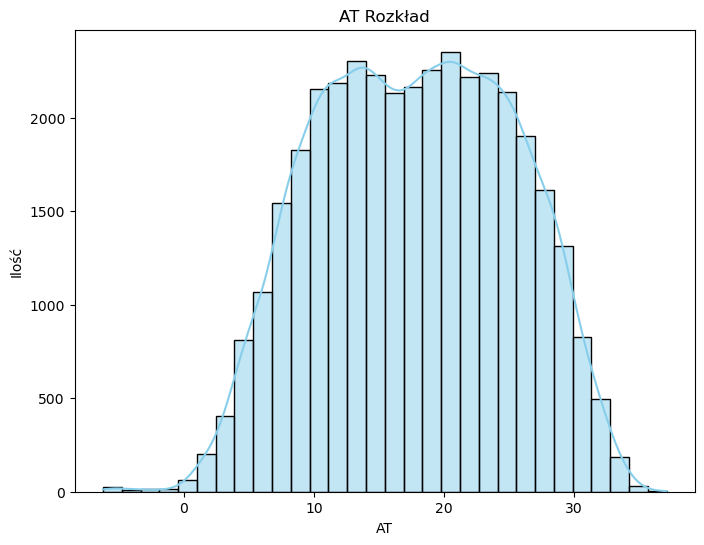

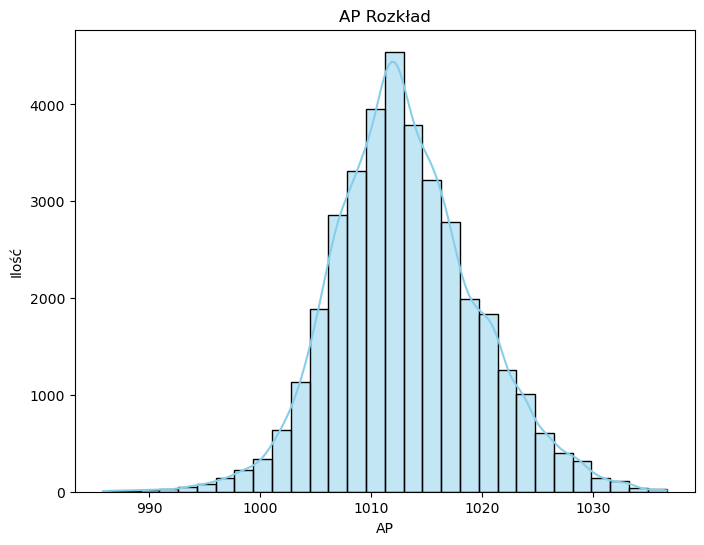

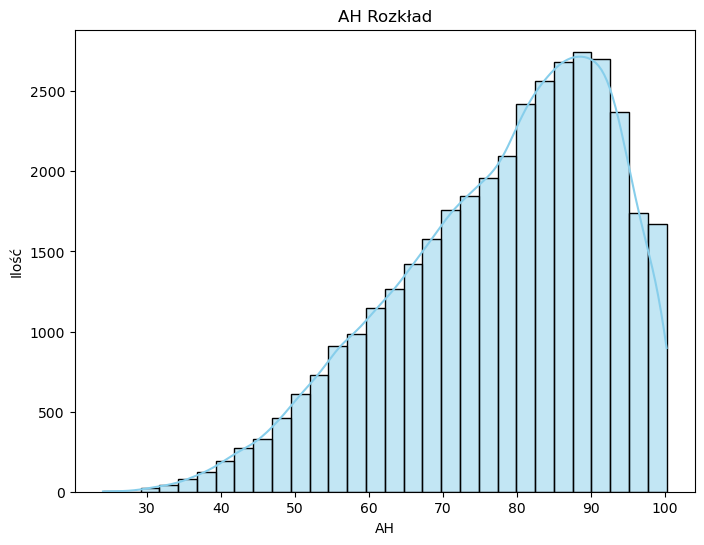

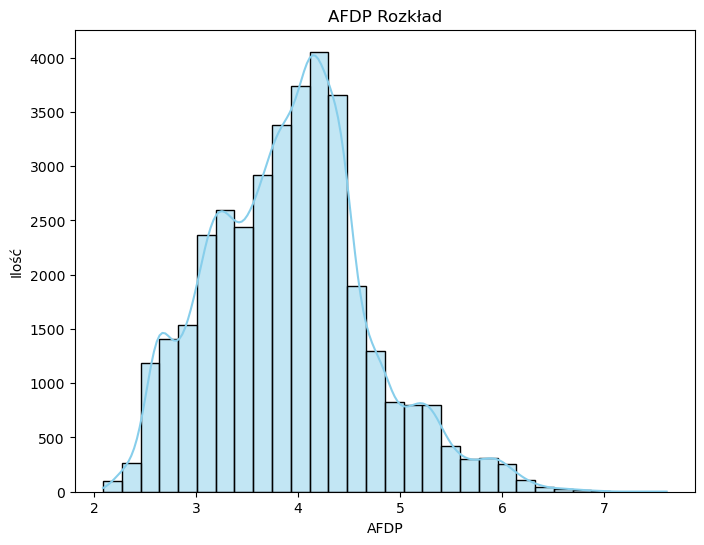

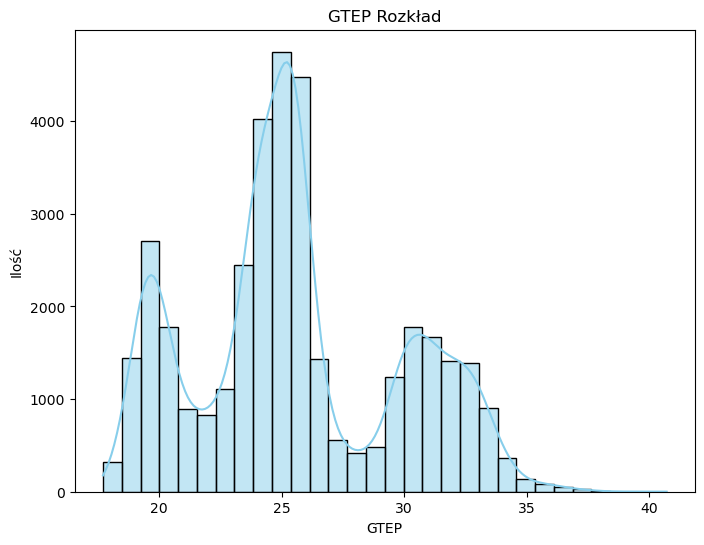

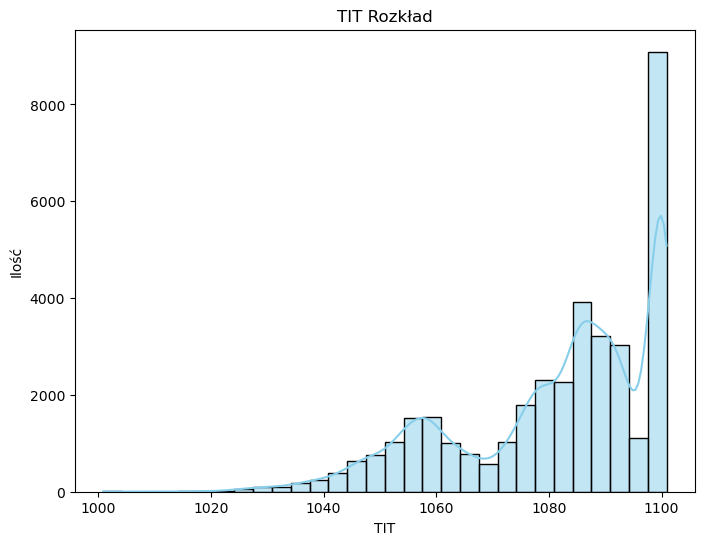

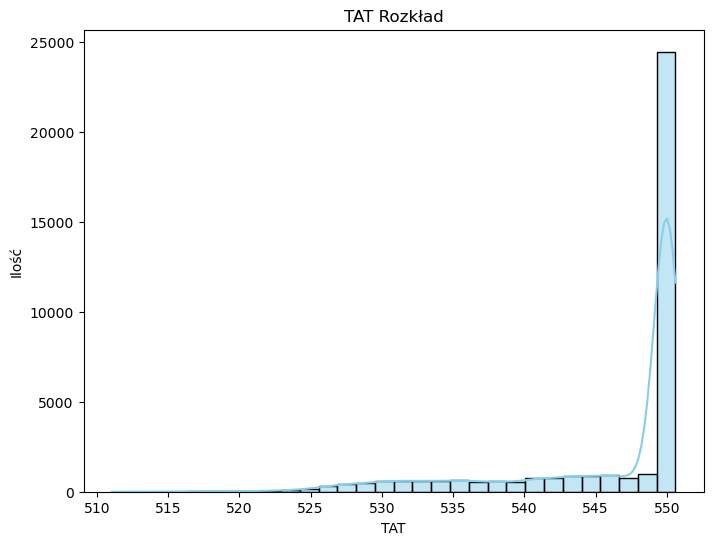

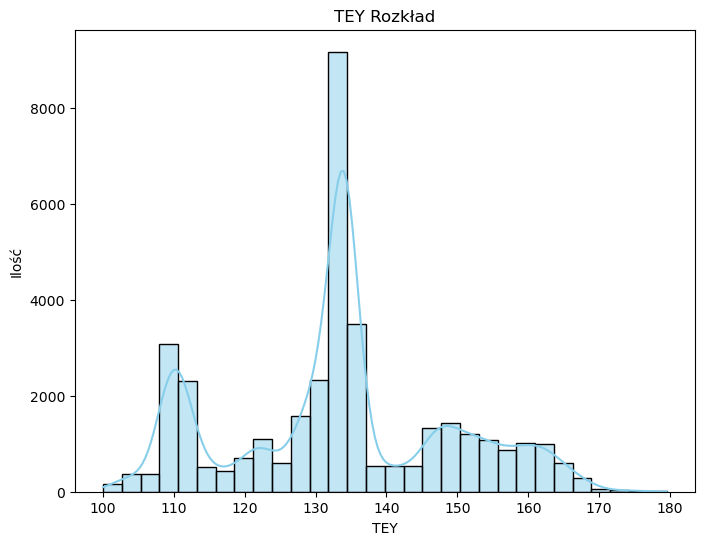

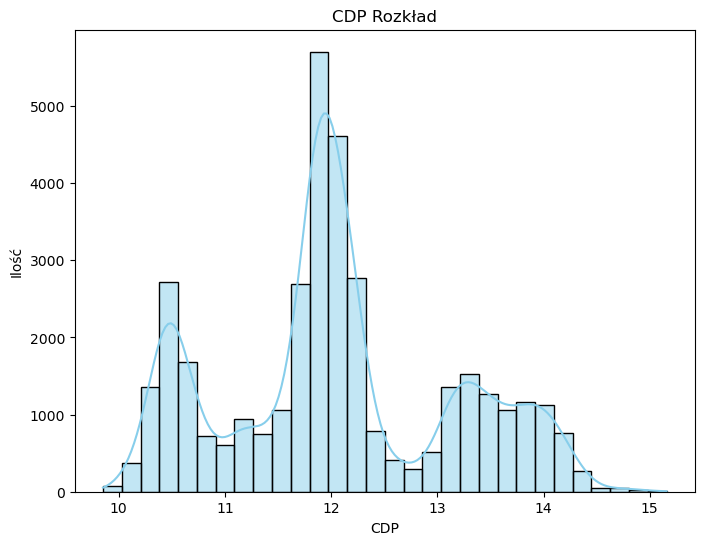

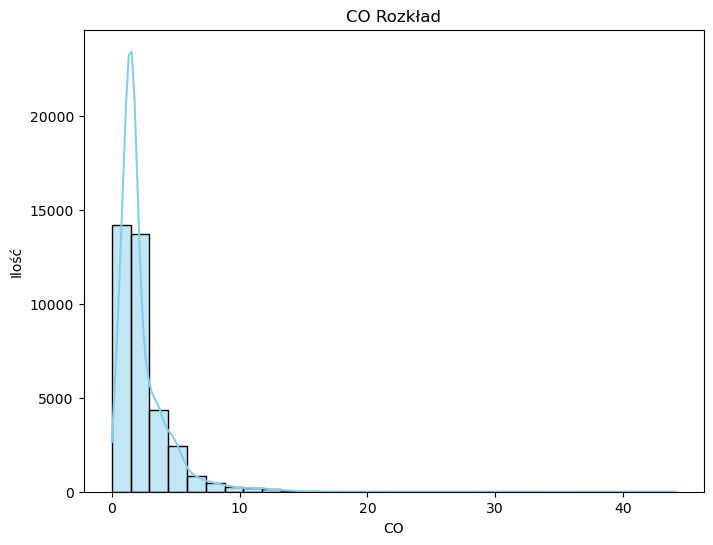

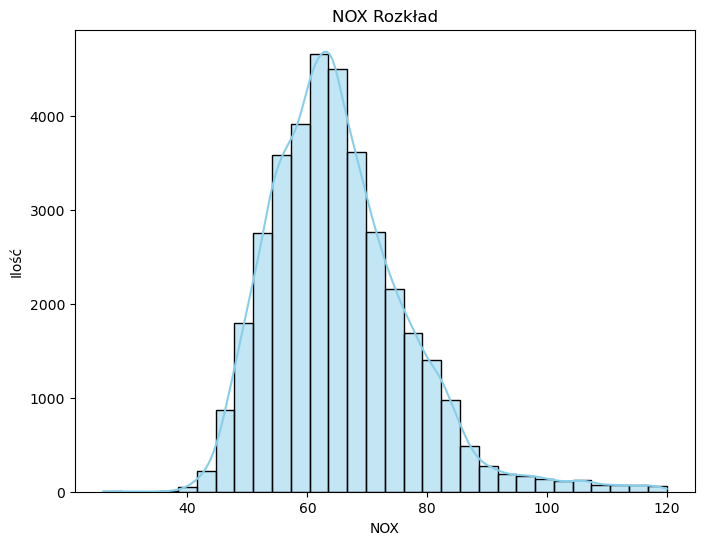

In [42]:
# ista kolumn do wygenerowania histogramów
cols = ['AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP', 'CO', 'NOX']

# Wskazanie lokalizacji histogramów

output_directory = 'C:/Users/jmoni/Desktop/histogramy' 

for col in cols:
    plt.figure(figsize=(8, 6))
    sns.histplot(x=col, data=df, bins=30, kde=True, color='skyblue')
    plt.title(f"{col} Rozkład")
    plt.xlabel(col)
    plt.ylabel("Ilość")
    
    # Zapisz wykres do pliku w wskazanej lokalizacji
    output_path = os.path.join(output_directory, f"{col}.png")
    plt.savefig(output_path)
    
    plt.show()

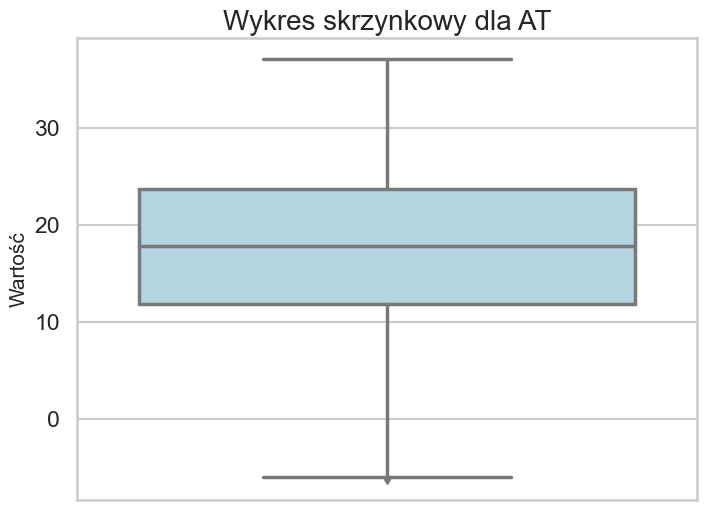

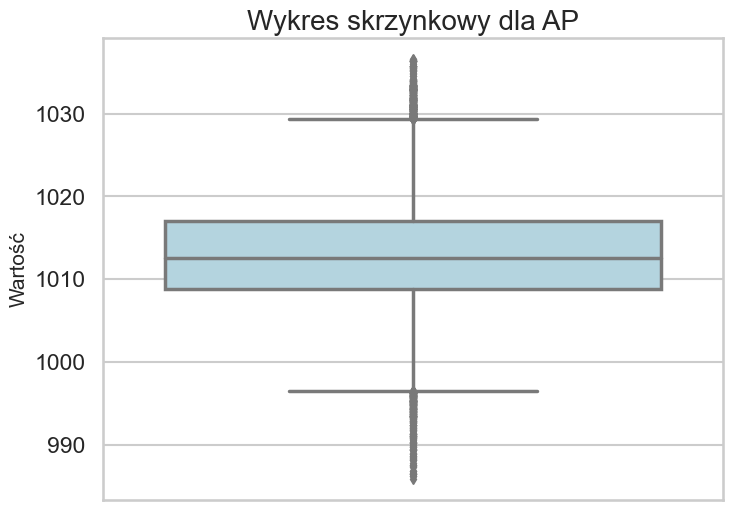

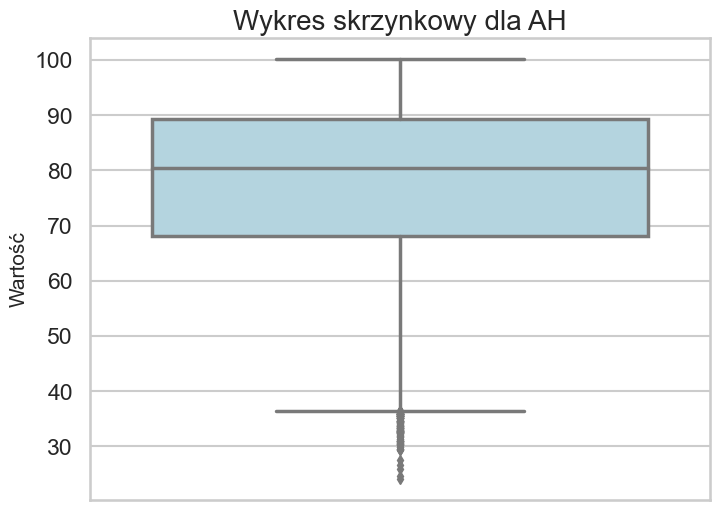

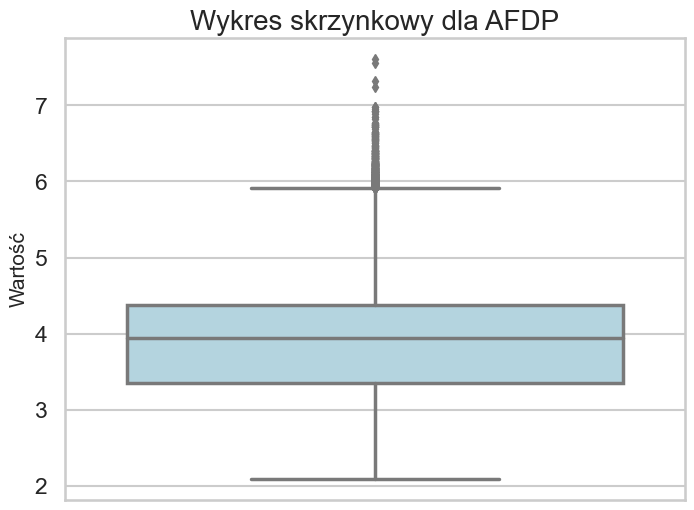

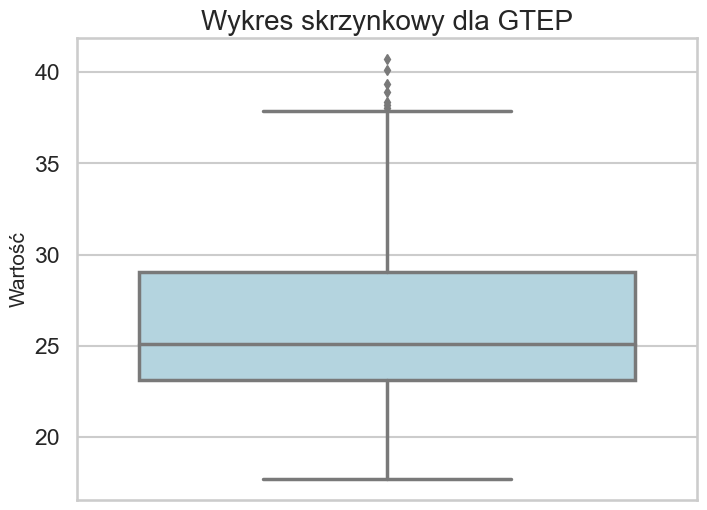

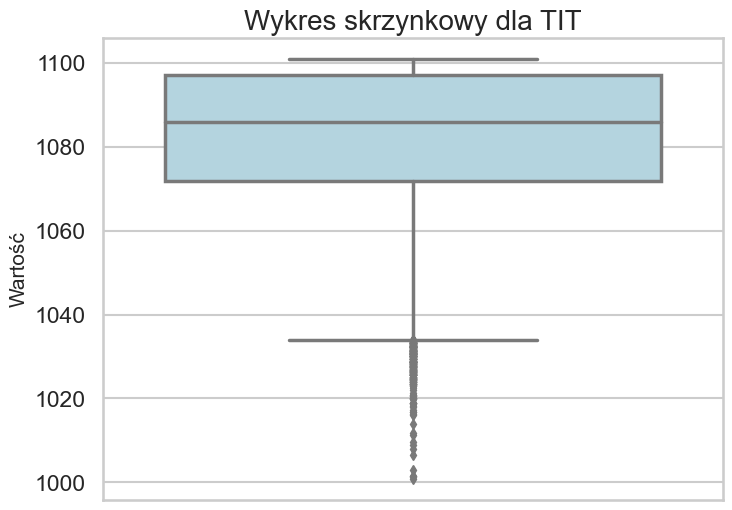

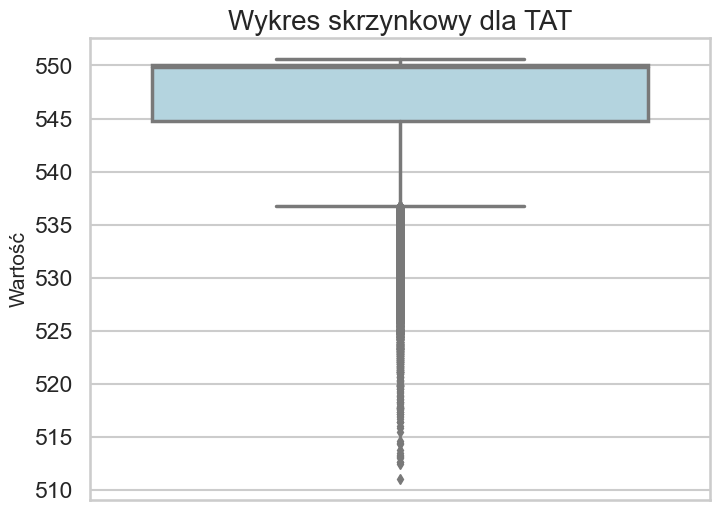

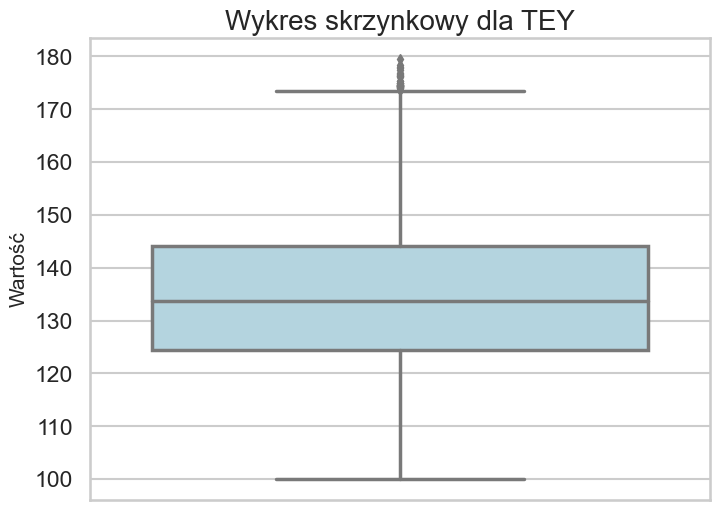

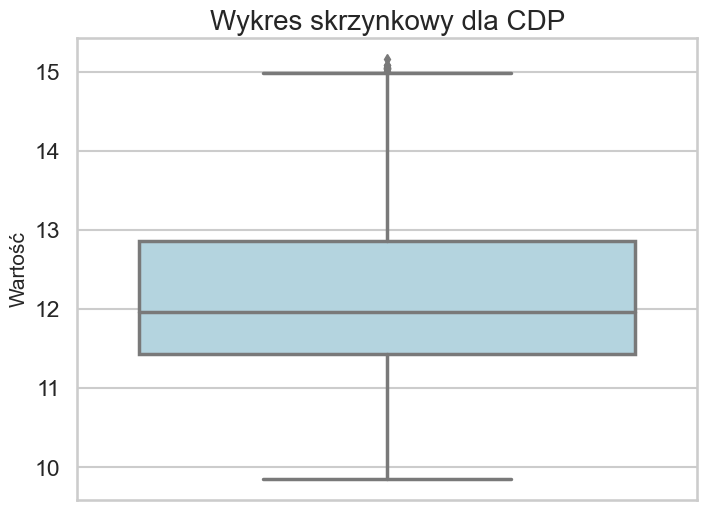

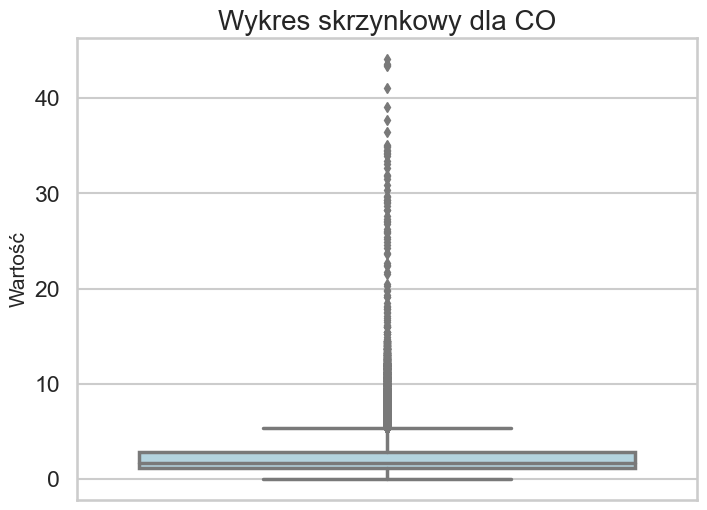

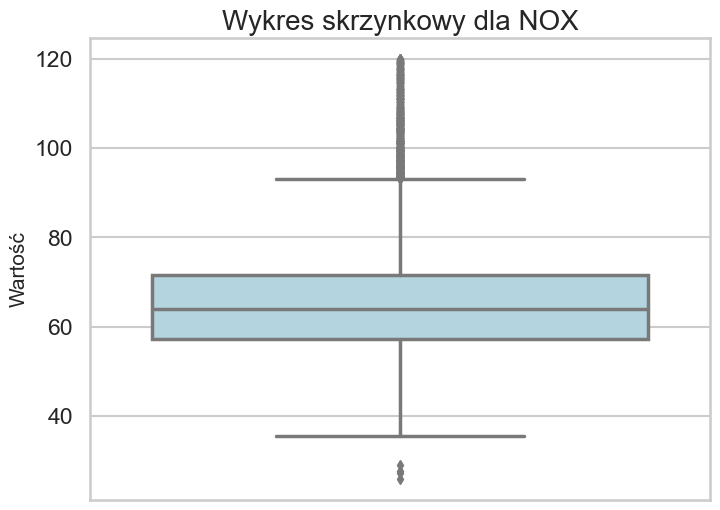

In [25]:
# Lista kolumn do wygenerowania boxplot
cols = ['AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP', 'CO', 'NOX']

# Wskazanie lokalizacji dla wykresów

output_directory = 'C:/Users/jmoni/Desktop/box' 

# Określenie stylu

sns.set_style('whitegrid')
sns.set_context('talk')

for col in cols:
    plt.figure(figsize=(8, 6))
    sns.boxplot(y=df[col], color='lightblue', linewidth=2.5)
    plt.title(f'Wykres skrzynkowy dla {col}', fontsize=20)
    plt.ylabel('Wartość', fontsize=15)
    
    output_path = os.path.join(output_directory, f"{col}.png")
    plt.savefig(output_path)
    
    plt.show()

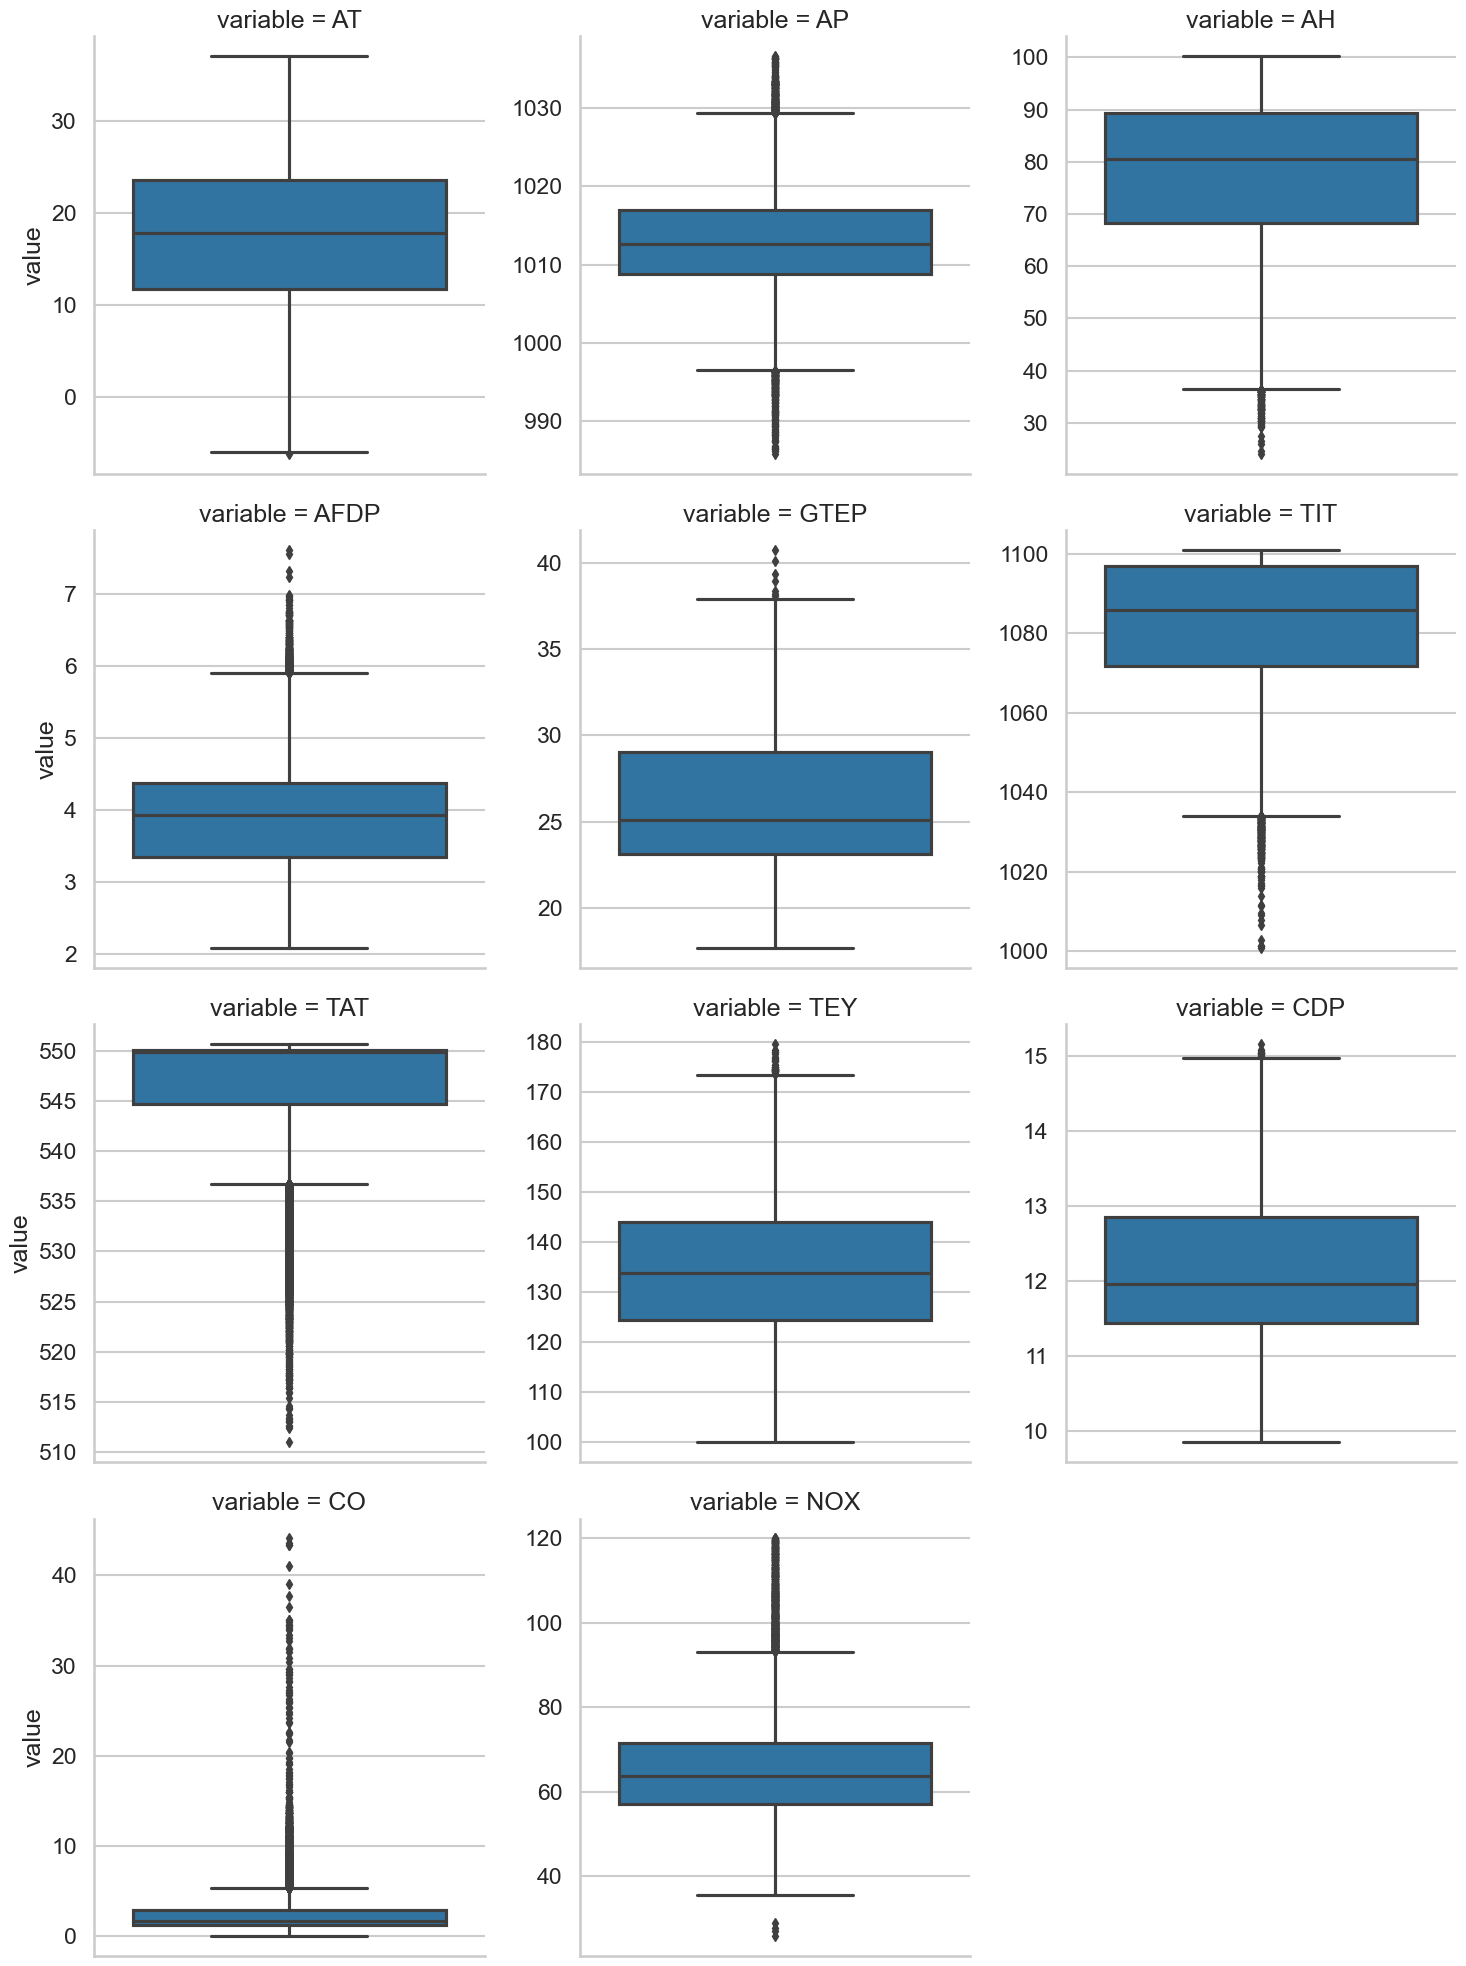

In [31]:
# Wykresy skrzynkowe dla wszystkich zmiennych
sns.set_style('whitegrid')
sns.set_context('talk')
sns.catplot(
    y='value',
    data=df.melt(value_vars=cols),
    col='variable',
    kind='box',
    col_wrap=3,
    sharex=False, 
    sharey=False,
);

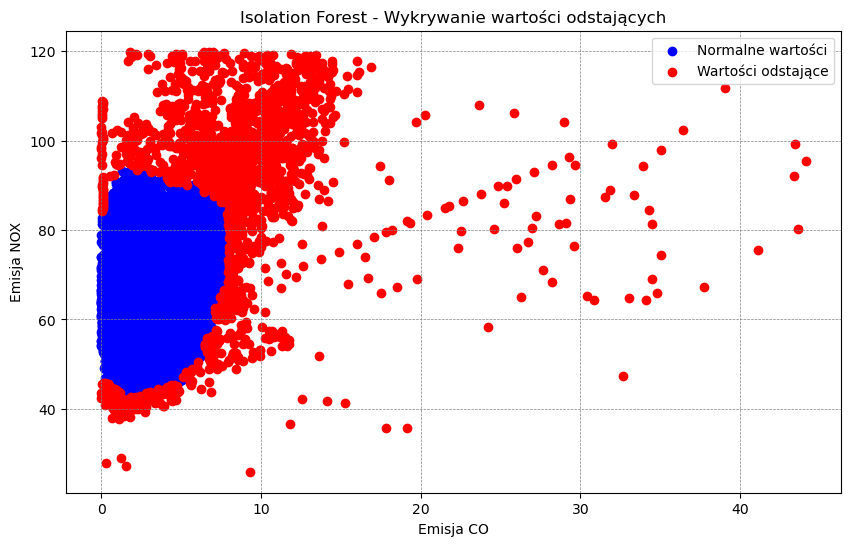

In [40]:
# Wybranie odpowiednich kolumny do analizy
X = df[['CO', 'NOX']]

# Model Isolation Forest
model = IsolationForest(contamination=0.05)  # contamination to poziom odstających, możesz dostosować go do swoich potrzeb
model.fit(X)

# Predykcja modelu
outliers = model.predict(X)

# Tworzenie maski dla wartości odstających i normalnych
mask_outliers = outliers == -1
mask_normal = outliers == 1

# Tworzenie wykresu
plt.figure(figsize=(10, 6))  # Zwiększamy rozmiar wykresu dla lepszej czytelności
plt.scatter(X.loc[mask_normal, 'CO'], X.loc[mask_normal, 'NOX'], c='blue', label='Normalne wartości')
plt.scatter(X.loc[mask_outliers, 'CO'], X.loc[mask_outliers, 'NOX'], c='red', label='Wartości odstające')

# Tytuł i etykiety osi
plt.title('Isolation Forest - Wykrywanie wartości odstających')
plt.xlabel('Emisja CO')
plt.ylabel('Emisja NOX')

# Legenda
plt.legend()

# Siatka
plt.grid(which='major', linestyle='--', linewidth=0.5, color='grey')

# Pokaż wykres
plt.show()

Widzimy duże skupisko normalnych wartości w lewym dolnym obszarze wykresu, co wskazuje na to, że większość pomiarów CO i NOx mieści się w niskich zakresach dla obu zmiennych. Obszar ten może być interpretowany jako "praca 
z pełnym obciążeniem", gdzie zarówno emisja CO, jak i NOx są na oczekiwanym poziomie.

Wartości odstające, oznaczone na czerwono, znajdują się poza głównym skupiskiem i są rozproszone głównie w górnej części wykresu, co wskazuje na wyższe wartości emisji NOx przy różnych poziomach emisji CO

Indeksy odstających obserwacji:
Index([  453,   671,   697,   927,   928,  1194,  1557,  1668,  1671,  1672,
       ...
       36596, 36597, 36598, 36599, 36600, 36669, 36728, 36729, 36730, 36732],
      dtype='int64', length=1837)


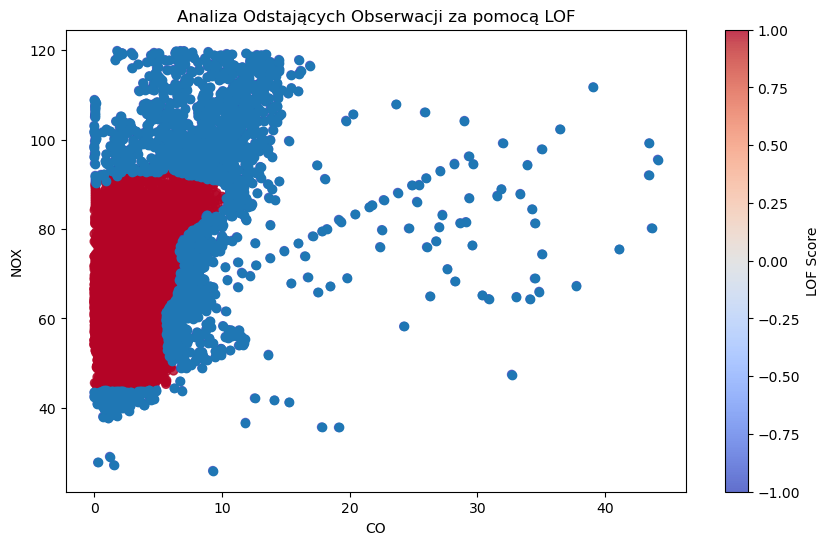

In [32]:
# Wybranie odpowiednich kolumny do analizy
X = df[['CO', 'NOX']]

# Model LOF
lof_model = LocalOutlierFactor(n_neighbors=2000, contamination=0.05)  # Możesz dostosować parametry w zależności od swoich potrzeb

# Dopasowanie modelu do danych 
outliers = lof_model.fit_predict(X)

# Wyznaczenie indeksów odstających obserwacji
outlier_indices = X.index[outliers == -1]

# Indeksy odstających obserwacji
print("Indeksy odstających obserwacji:")
print(outlier_indices)

# Wizualizacja danych
plt.figure(figsize=(10, 6))
plt.scatter(X['CO'], X['NOX'], c=outliers, cmap='coolwarm', alpha=0.8)
plt.xlabel('CO')
plt.ylabel('NOX')
plt.title('Analiza Odstających Obserwacji za pomocą LOF')
plt.colorbar(label='LOF Score')
plt.scatter(X['CO'].iloc[outlier_indices], X['NOX'].iloc[outlier_indices])
plt.show()

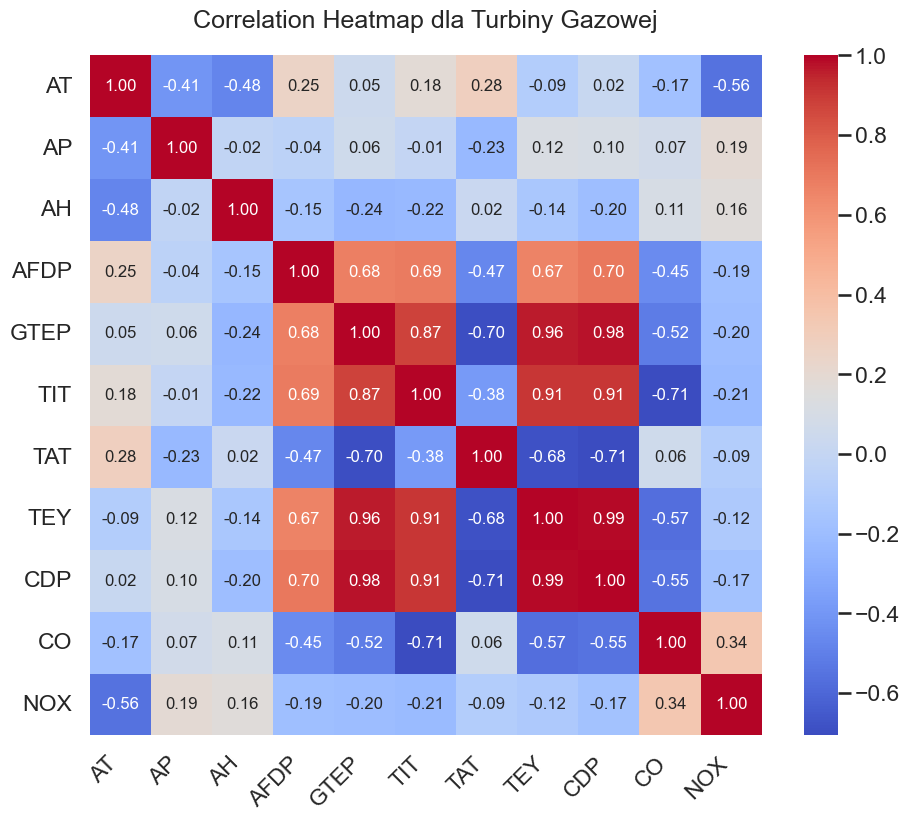

In [52]:
# Obliczanie macierzy korelacji
correlation_matrix = df.corr()

# Ustawienie większego rozmiaru
plt.figure(figsize=(12, 10))

# Tworzenie heatmapy z dostosowanymi adnotacjami
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={'size': 12})

# Ustawienie tytułu
plt.title('Correlation Heatmap dla Turbiny Gazowej', pad=20)

# Obracanie etykiet osi x
plt.xticks(rotation=45, ha='right')

# Obracanie etykiet osi y
plt.yticks(rotation=0)

# Dostosowanie marginesów
plt.subplots_adjust(bottom=0.2, left=0.2)

# Wyświetlanie wykresu
plt.show()

Tutaj parametry można podzielić na naturalne i techniczne. Parametry naturalne to odpowiednio temperatura, wilgotność i ciśnienie powietrza. Parametry techniczne to charakterystyka pracy turbin gazowych. Widzimy, że parametry techniczne są ze sobą dość silnie skorelowane (z wyjątkiem temperatury za turbiną)